In [1]:
import base64
from __future__ import print_function # py 2.7 compat.
import ipywidgets as widgets # Widget definitions.
from traitlets import Unicode # Traitlet needed to add synced attributes to the widget.

This is a custom widget that allows the user to upload file data to the notebook server.  The file data is sent via a statefull `value` attribute of the widget.  The widget has an upload failed event that fires in the front-end and is echoed to the back-end using a custom msg.

In [2]:
class FileWidget(widgets.DOMWidget):
    _view_name = Unicode('FilePickerView').tag(sync=True)
    _view_module = Unicode('filepicker').tag(sync=True)

    value = Unicode().tag(sync=True)
    filename = Unicode().tag(sync=True)
    
    def __init__(self, **kwargs):
        """Constructor"""
        widgets.DOMWidget.__init__(self, **kwargs) # Call the base.
        
        # Allow the user to register error callbacks with the following signatures:
        #    callback()
        #    callback(sender)
        self.errors = widgets.CallbackDispatcher(accepted_nargs=[0, 1])
        
        # Listen for custom msgs
        self.on_msg(self._handle_custom_msg)

    def _handle_custom_msg(self, content):
        """Handle a msg from the front-end.

        Parameters
        ----------
        content: dict
            Content of the msg."""
        if 'event' in content and content['event'] == 'error':
            self.errors()
            self.errors(self)
    

In [3]:
%%javascript

requirejs.undef('filepicker');

define('filepicker', ["jupyter-js-widgets"], function(widgets) {

    var FilePickerView = widgets.DOMWidgetView.extend({

        render: function() {
            // Render the view.
            this.setElement($('<input />')
                .attr('type', 'file'));
        },
        
        events: {
            // List of events and their handlers.
            'change': 'handle_file_change',
        },
       
        handle_file_change: function(evt) { 
            // Handle when the user has changed the file.
            
            // Retrieve the first (and only!) File from the FileList object
            var file = evt.target.files[0];
            if (file) {

                // Read the file's textual content and set value to those contents.
                var that = this;
                var file_reader = new FileReader();
                file_reader.onload = function(e) {
                    that.model.set('value', e.target.result);
                    that.touch();
                }
                file_reader.readAsText(file);
            } else {

                // The file couldn't be opened.  Send an error msg to the
                // back-end.
                this.send({ 'event': 'error' });
            }

            // Set the filename of the file.
            this.model.set('filename', file.name);
            this.touch();
        },
    });
    
    return {
        FilePickerView: FilePickerView
    };  
});

<IPython.core.display.Javascript object>

The following shows how the file widget can be used.

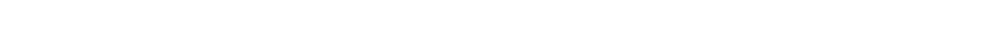

In [4]:
file_widget = FileWidget()

# Register an event to echo the filename when it has been changed.
def file_loading(change):
    print("Loading %s" % file_widget.filename)
file_widget.observe(file_loading, names='filename')

# Register an event to echo the filename and contents when a file
# has been uploaded.
def file_loaded(change):
    print("Loaded, file contents: %s" % file_widget.value)
file_widget.observe(file_loaded, names='value')

# Register an event to print an error message when a file could not
# be opened.  Since the error messages are not handled through
# traitlets but instead handled through custom msgs, the registration
# of the handler is different than the two examples above.  Instead
# the API provided by the CallbackDispatcher must be used.
def file_failed():
    print("Could not load file contents of %s" % file_widget.filename)
file_widget.errors.register_callback(file_failed)

file_widget